# Interpreting the ML models used to analyze the 'Automobile Data Set' from the UC Irvine Machine Learning repository

This notebook is used to analyze the 'Automobile Data Set' from the UC Irvine Machine Learning repository. The dataset is available [here](https://archive.ics.uci.edu/ml/datasets/Automobile). This notebook is based on a previous project we did, which can be accessed [here](https://github.com/gabrielleuzinger/Automobile_price). 

**Therefore, I do not make many considerations about the regression models used. The focus is on the interpretation of what the ML models used to predict the cars price are doing**.

Interpretability of ML models is important because it is used to assess many other characterisitcs of the models, such as [(DOSHI-VELEZ; KIM, 2017)](https://arxiv.org/abs/1702.08608):

1. Fairness or unbiasedness
2. Privacy
3. Reliability or robustness
4. Causality
5. Trust

"There  is  little  consensus  on  what  interpretability  in  machine  learning is and how to evaluate it for benchmarking" (DOSHI-VELEZ; KIM, 2017). One option is to use use Shapley Values, a method from coalitional game theory that tells us how to fairly distribute the "payout" among the features (MOLNAR, 2021). **We use this explanation method because it is the only method with a solid theory because it satisfies the properties Efficiency, Symmetry, Dummy and Additivity** (MOLNAR, 2021).

**Most of the models used in this notebook do not require the use of Shapley Values to be explained**. They are all straightfoward methods that can easily be interpreted and explained, different from the so-called 'black-box methods', such as neural networks. **However, I use this notebook to understand the core principles of the Shapley Values method and practice with the [SHAP library for Python](https://shap.readthedocs.io/en/latest/). Therefore, starting with this simpler models is quite useful**.

The notebook is divided as follows:
    
1. Data exploration
2. Training the ML models
3. Interpreting the ML models
4. Conclusion

----------

## 1. Data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

----------

### Getting the data

In [2]:
attributes = ['symboling','normalized_losses','make','fuel_type','aspiration','num_of_doors','body_style',
           'drive_wheels','engine_location','wheel_base','length','width','height','curb_weight','engine_type',
           'num_of_cylinders','engine_size','fuel_system','bore','stroke','compression_ratio','horsepower',
           'peak_rpm','city_mpg','highway_mpg','price']
df_data = pd.read_csv('/Users/leuzinger/Dropbox/Data Science/Awari/SHAP/Automobile Data Set/imports-85(1).data',names=attributes)
df_data.reset_index(inplace=False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_data.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


----------

### Data Cleaning

After importing the data, we need to do some data cleaning. For now, we just substitute the "?" values by NaN. We also transform some numerical columns that were objects to float. Finally, we drop all the rows without a price for the car, as they do not help us train our model. Finally, as we will only consider the numerical variables in this notebook, we will drop all the columns with categorical values.

In [3]:
df_data['num_of_doors'].replace("?","four",inplace=True)
df_data.replace("?",np.nan,inplace=True)
df_data.dropna(subset = ["price"], inplace=True)
num_cols = ['symboling', 'normalized_losses', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'engine_size', 'bore', 'stroke',
       'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price']
df_data[num_cols] = df_data[num_cols].apply(pd.to_numeric, errors='coerce')

cat_cols = df_data.select_dtypes(include=['object', 'bool']).columns

df_data.drop(columns=cat_cols, inplace=True)

df_data.reset_index(drop=True,inplace=True)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          201 non-null    int64  
 1   normalized_losses  164 non-null    float64
 2   wheel_base         201 non-null    float64
 3   length             201 non-null    float64
 4   width              201 non-null    float64
 5   height             201 non-null    float64
 6   curb_weight        201 non-null    int64  
 7   engine_size        201 non-null    int64  
 8   bore               197 non-null    float64
 9   stroke             197 non-null    float64
 10  compression_ratio  201 non-null    float64
 11  horsepower         199 non-null    float64
 12  peak_rpm           199 non-null    float64
 13  city_mpg           201 non-null    int64  
 14  highway_mpg        201 non-null    int64  
 15  price              201 non-null    int64  
dtypes: float64(10), int64(6)
m

### Data visualization

A "quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute" (GÉRON, 2019).

We start our anlysis having a look at the correlation matrix of the features in the dataset. Correlation is important to understand the ML model because "interpretation remains difficult when features are strongly correlated. Because if they have a very strong correlation, it only makes sense to analyze the effect of changing both features together and not in isolation" [(MOLNAR, 2021)](https://christophm.github.io/interpretable-ml-book/).

**We verify that city mpg and highway mpg have the highest correlation between the features. Wheel base, lenght, width, and curb weight are also highly correlated, as expected**. 

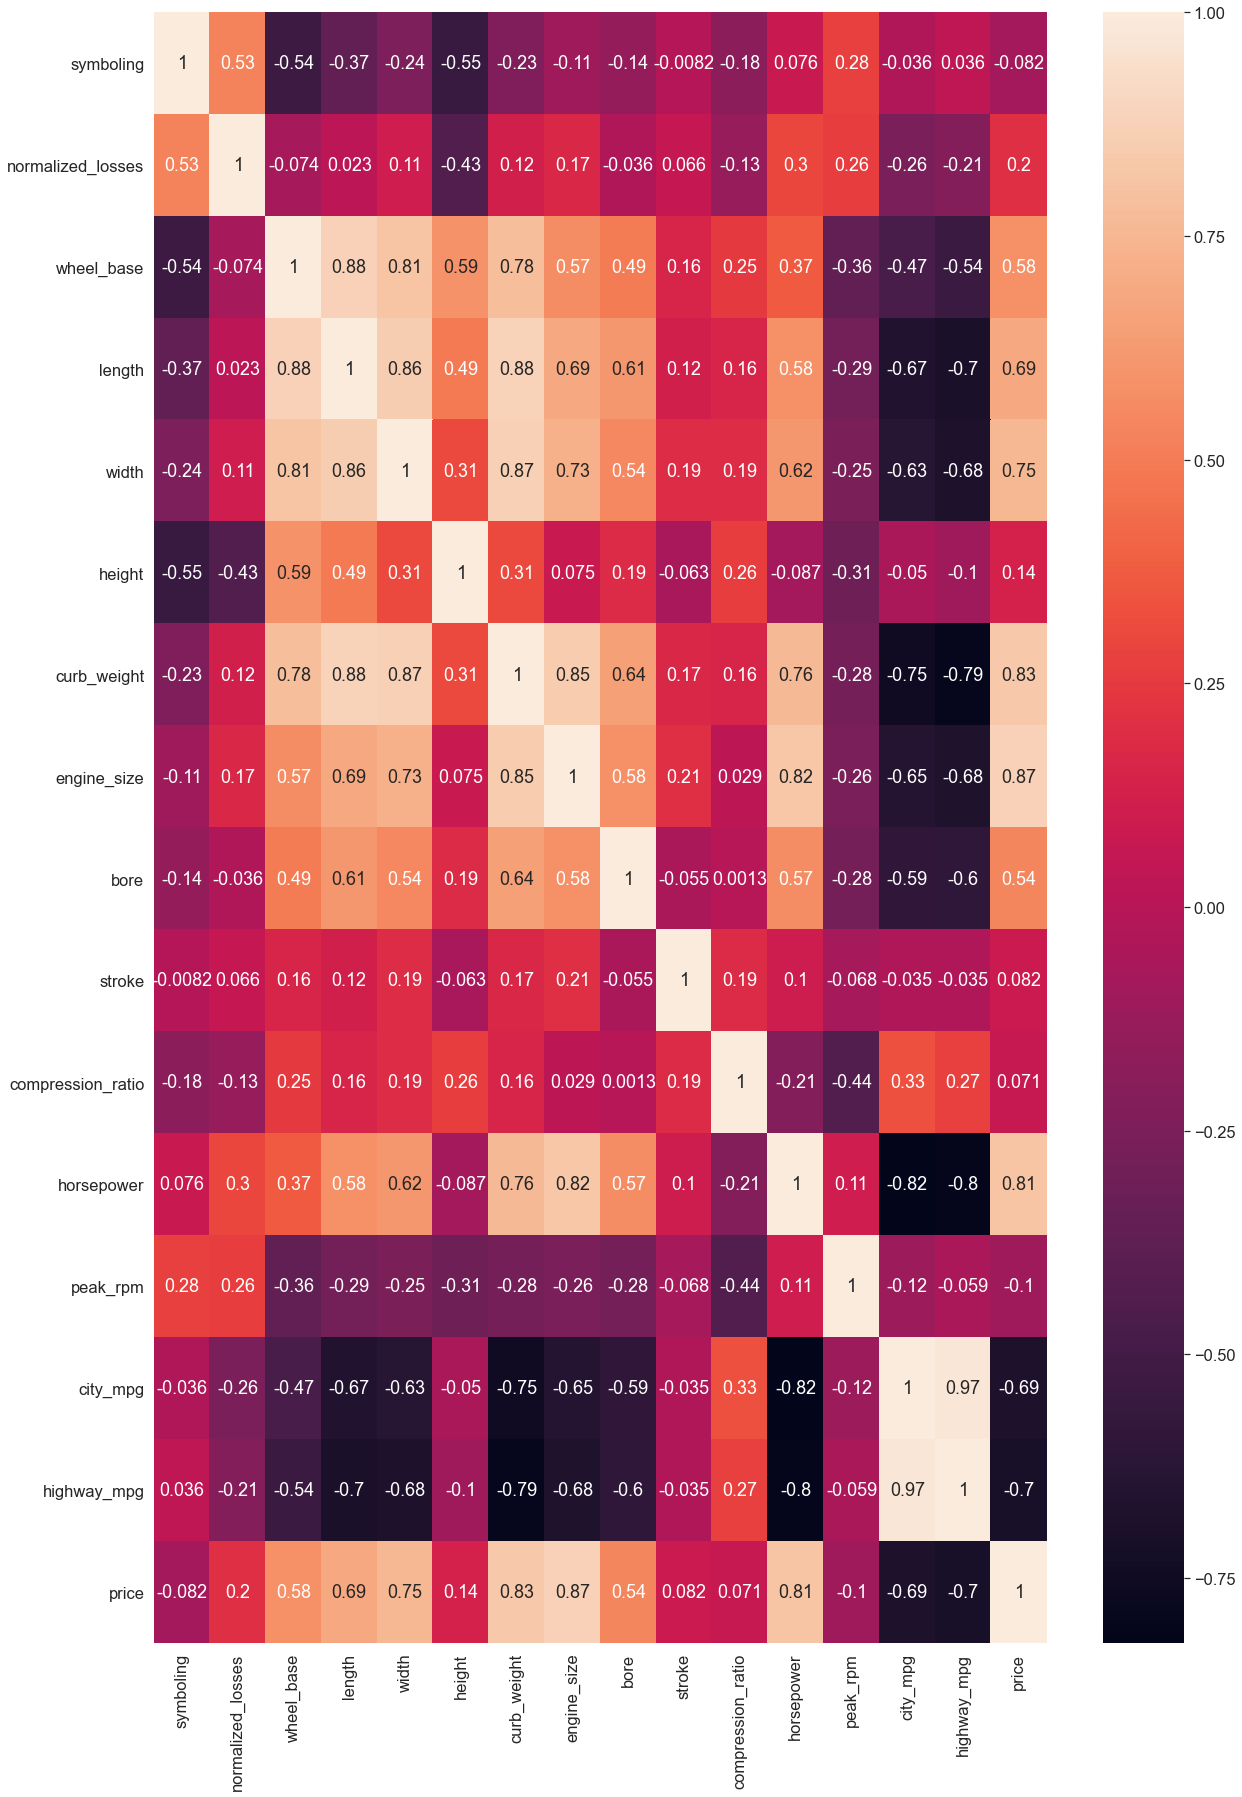

In [4]:
import seaborn as sns

corr_matrix = df_data.corr()

plt.figure(figsize=(20, 30))
sns.set_theme()
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(corr_matrix,annot=True)
plt.show()

----------

### Creating the Train and Test sets

Creating a test set at the beginning of the project avoid *data snooping* bias, i.e., "when you estimate the generalization error using the test set, your estimate will be too optimistic, and you will launch a system that will not perform as well as expected" (GÉRON, 2019). To avoid this problem, we divide our data into a train and a test set. 

Besides, "the key to a fair comparison of machine learning algorithms is ensuring that each algorithm is evaluated in the same way on the same data. You can achieve this by forcing each algorithm to be evaluated on a consistent test harness" (BROWNLEE, 2016). In this project, we do this by using the same split in the cross validation. We use the KFold function from the sklearn library with a random value rs as the random_state parameter. Although the rs value change everytime the notebook is run, once it is set, the same rs value is used in all the models. This guarantees that all the models are evaluated on the same data.

In [5]:
from sklearn.model_selection import train_test_split
from random import randrange

car_X = df_data.drop(['price'],axis=1)
car_y = df_data['price']

rs = randrange(10000)

X_train, X_test, y_train, y_test = train_test_split(car_X, car_y, test_size=0.2, random_state=rs)

In [6]:
car_X_train = X_train.copy()
car_y_train = y_train.copy()
car_X_test = X_test.copy()
car_y_test = y_test.copy()

----------

## 2. Training the ML models

Before creating the ML models, we need to prepare the data so that the ML algorithms will work properly.

First, we need to clean missing values from the dataset. We have three option to deal with it [(GÉRON, 2019)](https://www.amazon.com.br/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646):

1. Get ride of the rows with missing values
2. Get ride of the whole attirbute that have missing values
3. Set the values to some value (the median, the mean, zero, etc)

We use the median value. We create a pipeline to be used with the models we will test next. Second, we need to put all the attributes in the same scale because "Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales" (GÉRON, 2019). To do this we standardized all the numerical variables.

After preparing the data set, we are ready to select and train our ML model to predict the car price.

We use the following models:

1. Linear Regression
2. Ridge regression
3. Lasso regression 
4. Elastic Net
5. Decision Tree (CART)
6. k-Nearest Neighbors (KNN)
7. Support Vector Regression (SVR)

The models are evaluated using the mean absolute error (MAE), root square mean error (RMSE), and R².

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def estimator_scaler(estimator):
    imputer = SimpleImputer(strategy='median')
    pipeline = Pipeline(steps=[('i', imputer), ('scaler',StandardScaler()),('model', estimator)])
    return pipeline  

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

def estimator_cross_val (model,estimator,pipe,matriz,rs):
    pipe_ = pipe(estimator)
    scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error','r2']
    kfold = KFold(n_splits=10, random_state=rs,shuffle=True)
    scores = cross_validate(pipe_,car_X_train,car_y_train,cv=kfold,scoring=scoring)
    
    mae_scores = -scores.get('test_neg_mean_absolute_error')
    mae_mean = mae_scores.mean()
    mae_std = mae_scores.std()
    
    rmse_scores = -scores.get('test_neg_root_mean_squared_error')
    rmse_mean = rmse_scores.mean()
    rmse_std = rmse_scores.std()
    
    r2_scores = scores.get('test_r2')
    r2_mean = r2_scores.mean()
    r2_std = r2_scores.std()
    
    results_ = [model,mae_mean,mae_std,rmse_mean,rmse_std,r2_mean,r2_std]
    results_ = pd.Series(results_, index = matriz.columns)
    results = matriz.append(results_,ignore_index=True)
    return results

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import warnings

matriz = pd.DataFrame(columns=['model','MAE_mean','MAE_std','RMSE_mean','RMSE_std','R2_mean','R2_std'])

matriz = estimator_cross_val('Linear Regression',LinearRegression(),estimator_scaler,matriz,rs)
matriz = estimator_cross_val('Ridge Regression',Ridge(),estimator_scaler,matriz,rs)
matriz = estimator_cross_val('Lasso',Lasso(alpha=0.1),estimator_scaler,matriz,rs)
matriz = estimator_cross_val('Elastic Net',ElasticNet(alpha=0.1, l1_ratio=0.5),estimator_scaler,matriz,rs)
matriz = estimator_cross_val('KNN',KNeighborsRegressor(),estimator_scaler,matriz,rs)
matriz = estimator_cross_val('Decision Tree',DecisionTreeRegressor(random_state = rs),estimator_scaler,matriz,rs)
matriz = estimator_cross_val('SVR',SVR(),estimator_scaler,matriz,rs)
matriz

,model,MAE_mean,MAE_std,RMSE_mean,RMSE_std,R2_mean,R2_std
0,Linear Regression,2703.258819,432.229459,3674.422499,760.749661,0.742240,0.159217
1,Ridge Regression,2682.635164,448.443290,3651.359513,777.263304,0.745120,0.159071
2,Lasso,2703.139178,432.579094,3674.246737,760.952997,0.742265,0.159211
3,Elastic Net,2624.431895,469.186975,3603.511356,815.716956,0.752076,0.156505
4,KNN,2412.045000,595.436496,3808.430735,1353.728161,0.734386,0.179630
5,Decision Tree,1909.337500,515.747747,2762.431356,830.815821,0.848040,0.101579
6,SVR,5723.926119,1499.695174,8703.498579,2193.865176,-0.198778,0.149555


---------

# 3. Interpreting the ML models

First, we create feature importance plots, in which features with large absolute Shapley values are considered important. 

Second, we plot summary plots, that combines feature importance with feature effects. "Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance" (MOLNAR, 2021).

If we run the models enough times, we can see that the most important features significantly vary, although horsepower, curb weight, engine size, and city mpg are usually considered highly important features. Besides we also see that the models perform better when engine size and curb weight are the main features. 

Moreover, in all trials there is an interesting aspect in the regression models (Linear, Ridge, Lasso, and Elastic Net): the city mpg and the highway mpg have the opposite impact on the model, although being highly correlated. These pattern is also seen in the higly correlated features curb weight and lenght. **The explanation for this behavior is that correlation/multicollinearity in the features makes Shapley values unreliable because its it is a permutation-based interpretation method. Since it relies on random sampling, it will include unrealistic data instances if some features are correlated** [(LE GOUALHER, 2021)](https://www.datatrigger.org/post/interpretable_machine_learning_shap/).

In the KNN, Decision Tree and SVR models, these two features have similar impacts in the output. **Besides in these models the better the city mpg the lower the price, which is counterintuitive. We could expect that better mpg should result in higher prices because the car performs better**. One possible explanation is that the cars with better mpg are small and simpler cars, which have lower price, while bigger cars, such as SUV and Heavy Duty vehicles, are more expansive and have lower city mpg.

In [10]:
import shap

#First, we prepare the data to be used in the shap method

pipeline = Pipeline(steps=[('i', SimpleImputer(strategy='median')), ('scaler',StandardScaler())])
pipeline.fit(car_X_train)

car_X_train_tf = pipeline.transform(car_X_train)
car_X_test_tf = pipeline.transform(car_X_test)

car_X_train_tf = pd.DataFrame(car_X_train_tf,index = car_X_train.index, columns=car_X_train.columns)
car_X_test_tf = pd.DataFrame(car_X_test_tf,index = car_X_test.index, columns=car_X_test.columns)

car_X_train_tf_summary = shap.kmeans(car_X_train_tf, 10)

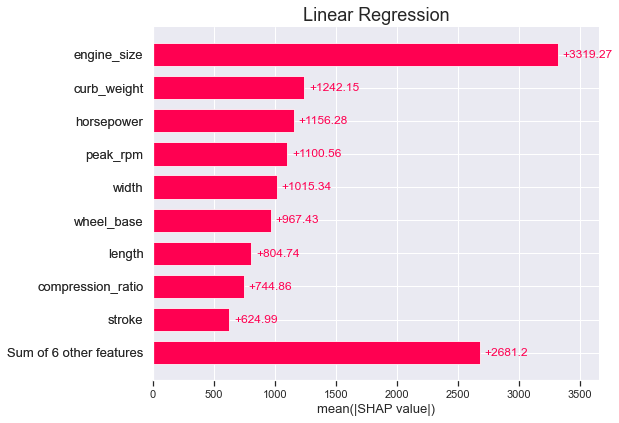

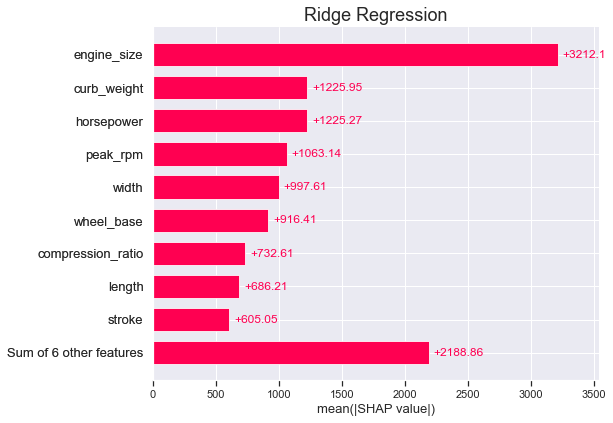

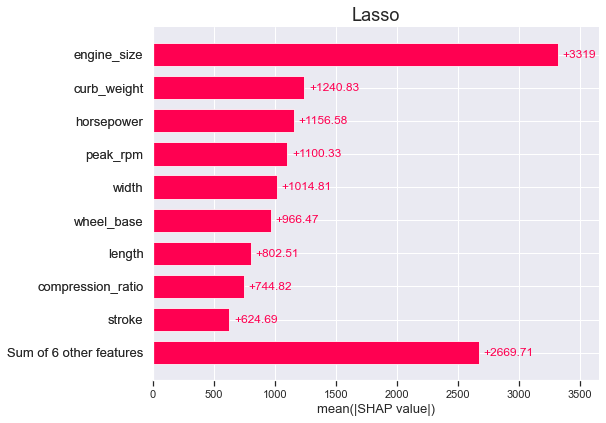

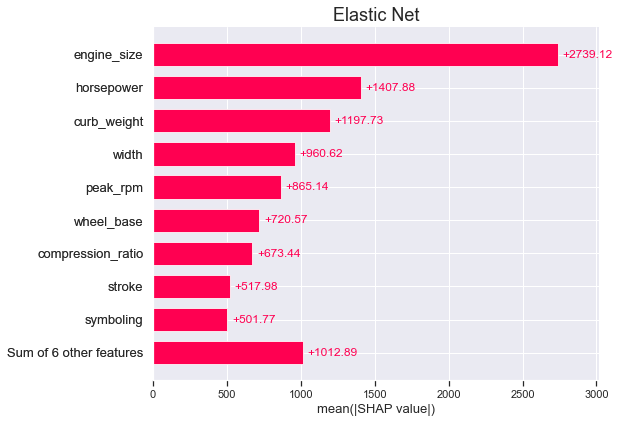

Permutation explainer: 161it [00:18,  3.96it/s]                         


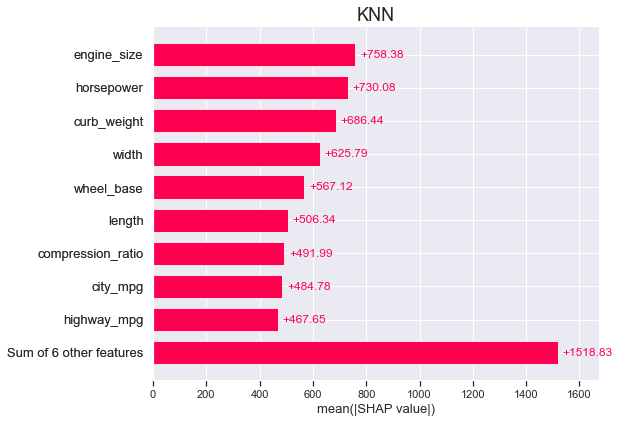

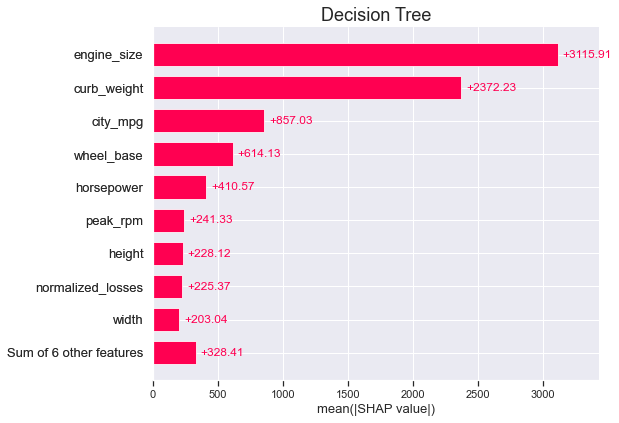

Permutation explainer: 161it [01:18,  1.78it/s]                         


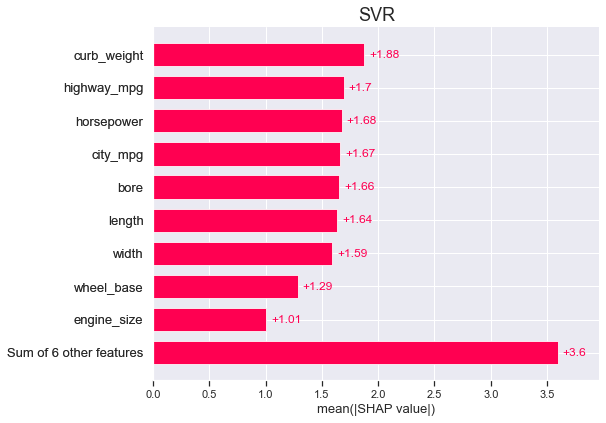

In [11]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.1),ElasticNet(alpha=0.1, l1_ratio=0.5),KNeighborsRegressor(),DecisionTreeRegressor(random_state=rs),SVR()]
models_str = ['Linear Regression','Ridge Regression','Lasso','Elastic Net','KNN','Decision Tree','SVR']

for k in range(len(models)):
    model = models[k]
    model.fit(car_X_train_tf,car_y_train)
    explainer = shap.Explainer(model.predict, car_X_train_tf)
    shap_values = explainer(car_X_train_tf)
    plt.title(models_str[k])
    shap.plots.bar(shap_values)

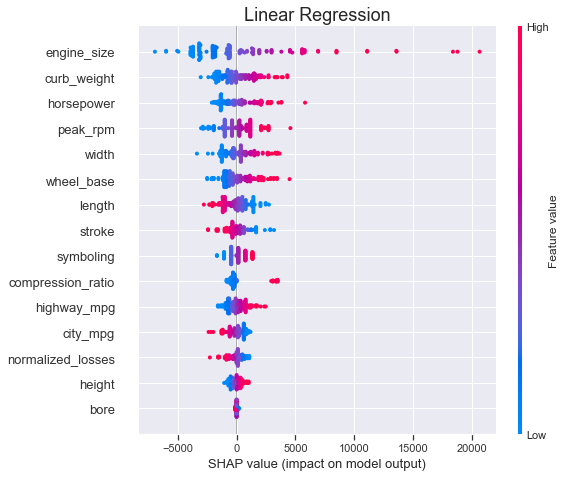

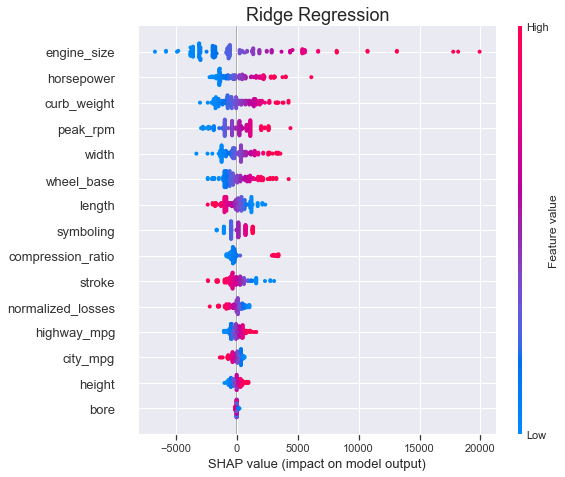

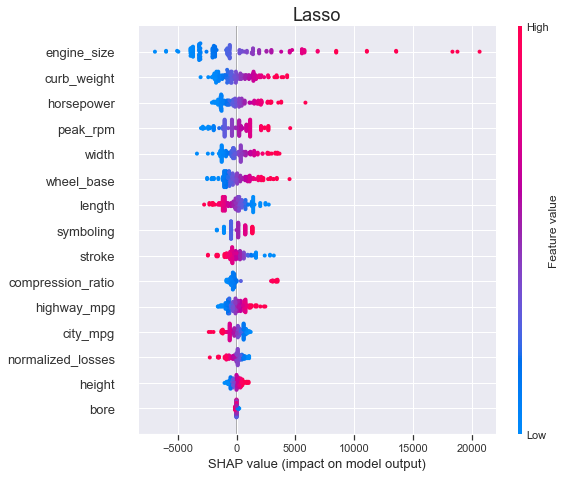

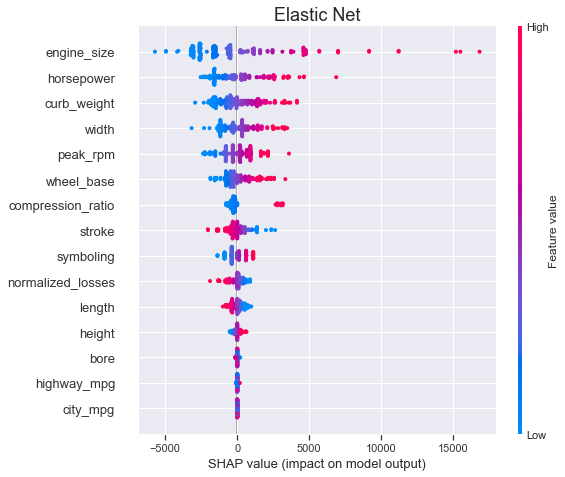

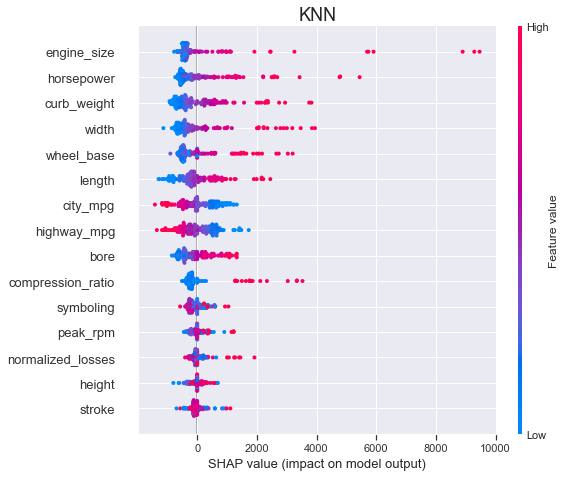

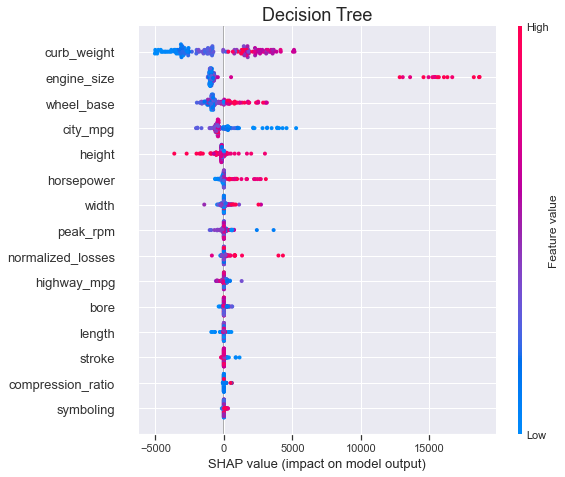

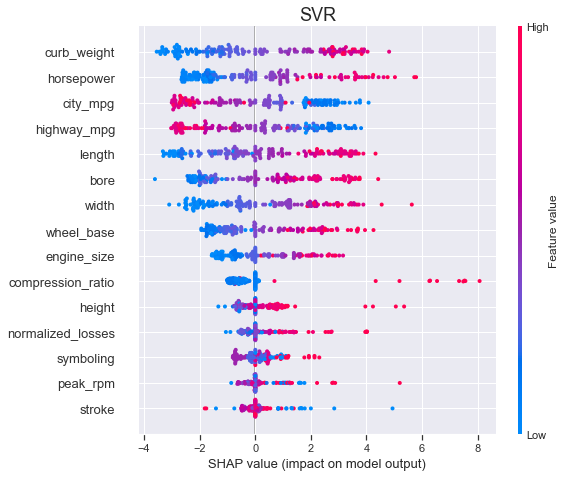

In [12]:
for k in range(len(models)):
    model = models[k]
    model.fit(car_X_train_tf,car_y_train)
    ex = shap.KernelExplainer(model.predict, car_X_train_tf_summary)
    shap_values = ex.shap_values(car_X_train_tf)
    plt.title(models_str[k])
    shap.summary_plot(shap_values, car_X_train_tf)

--------

We can explore a little further the two best performing models: Elastic Net and Decision Tree.

First, we verify if the feature importance in the Shapley Values method is in accordance with the expected feature importance of our models. **For the Elastic Net model, the feature importance are the weights of the model, Decision Tree algorithms offer importance scores based on the reduction in the criterion used to select split points**. We verify that the features importance in the SHAP algorithm is similar (but not the same) to the features importance we get directly from the models.

Then, we can cluster the Shapley values to find groups of similar instances. Although this can be more helpfull when interpreting classification models, the clustering may reveal interesting patterns in regression models too.

**For the Elastic Net model, we can distinguish two groups**. In the first, engine size and horsepower are driving the price forecast below average. In the second group, engine size and horsepower are doing the opposite, i.e., causing the price forecast to be above the average value, resulting in higher predictions.

**For the Decision Tree, we have three different groups**. The first is characterized by below-average prices, driven by the curb weight feature. In the second, the opposite occurs, that is, the curb weight is pushing prices above the average. The third group is the one with the highest price predictions, which are determined mainly by the engine size. 

Then, we can have a look at dependence plots for the main features of each model. For the Elastic Net model, there is not much information in these plots. 

In the case of the Decision Tree model, we see that increasing the curb weight result in an increase Shapley value until a certain point, where we see four ramifications of and increasing the curb weight have different impact in the Shapley values. For the engine size, we verify that until a certain point, it has almost no influence in the Shapley value. However, when this threshold is passed, increasing the engine size has a relevant impact in the increase of the Shapley values. These two patterns are consistent with the Decision Tree model.

Finally, we can plot force graphs to see how the features are impacting individual observations. We select the same three observations for each model, to see the differences between them. In these force plots, it is possible to see the patterns of each of the groups we detailed above.

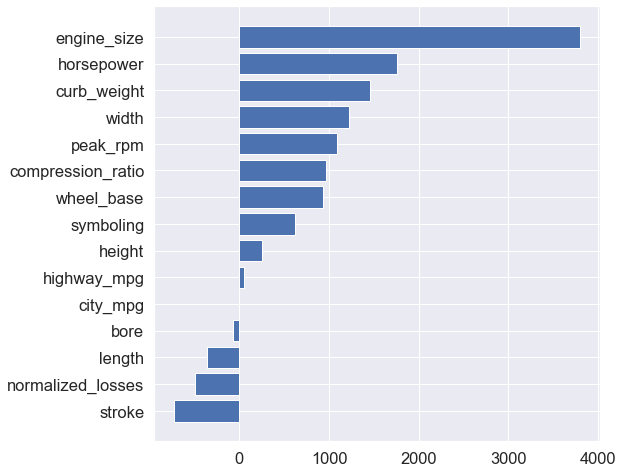

In [13]:
model = ElasticNet(alpha=0.1, l1_ratio=0.5)
model.fit(car_X_train_tf,car_y_train)
importance = model.coef_

elastic_importance = pd.DataFrame(car_X_train_tf.columns,columns=['feature'])
elastic_importance['weight'] = pd.DataFrame(importance)
elastic_importance = elastic_importance.sort_values(by=['weight'],ascending=False).reset_index(drop=True)

plt.figure(figsize=(8,8))
plt.barh(elastic_importance['feature'],elastic_importance['weight'])
plt.gca().invert_yaxis()

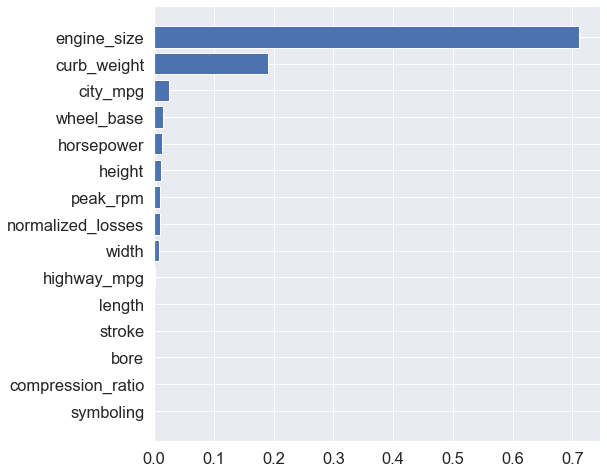

In [14]:
model = DecisionTreeRegressor(random_state=rs)
model.fit(car_X_train_tf,car_y_train)
importance = model.feature_importances_

tree_importance = pd.DataFrame(car_X_train_tf.columns,columns=['feature'])
tree_importance['weight'] = pd.DataFrame(importance)
tree_importance = tree_importance.sort_values(by=['weight'],ascending=False).reset_index(drop=True)

plt.figure(figsize=(8,8))
plt.barh(tree_importance['feature'],tree_importance['weight'])
plt.gca().invert_yaxis()

In [15]:
shap.initjs()
model = ElasticNet(alpha=0.1, l1_ratio=0.5)
model.fit(car_X_train_tf,car_y_train)
ex1 = shap.KernelExplainer(model.predict, car_X_train_tf_summary)
shap_values1 = ex1.shap_values(car_X_train_tf)
shap.force_plot(ex1.expected_value, shap_values1, car_X_train_tf)

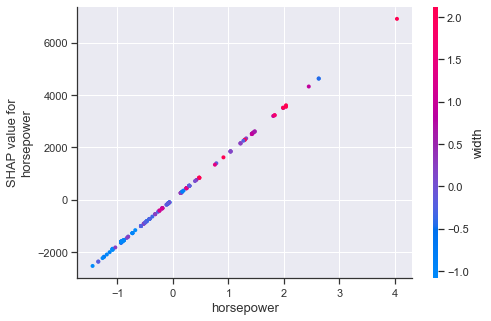

In [16]:
shap.dependence_plot("horsepower", shap_values1, car_X_train_tf)

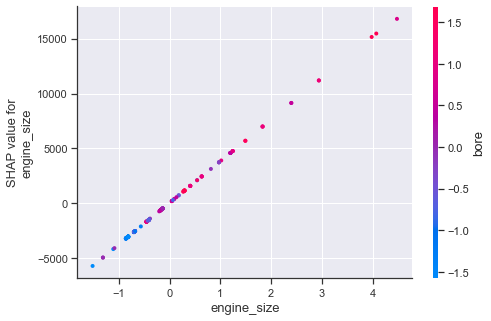

In [17]:
shap.dependence_plot("engine_size", shap_values1, car_X_train_tf)

In [18]:
sample = [137,58]
shap.force_plot(ex1.expected_value, shap_values1[sample[0],:], car_X_train_tf.iloc[sample[0],:])

In [19]:
shap.force_plot(ex1.expected_value, shap_values1[sample[1],:], car_X_train_tf.iloc[sample[1],:])

In [20]:
shap.initjs()
model = DecisionTreeRegressor(random_state = rs)
model.fit(car_X_train_tf,car_y_train)
ex2 = shap.KernelExplainer(model.predict, car_X_train_tf_summary)
shap_values2 = ex2.shap_values(car_X_train_tf)
shap.force_plot(ex2.expected_value, shap_values2, car_X_train_tf)

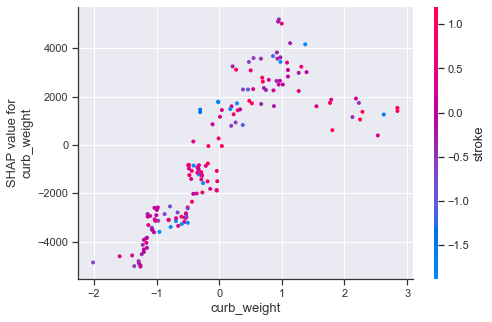

In [21]:
shap.dependence_plot("curb_weight", shap_values2, car_X_train_tf)

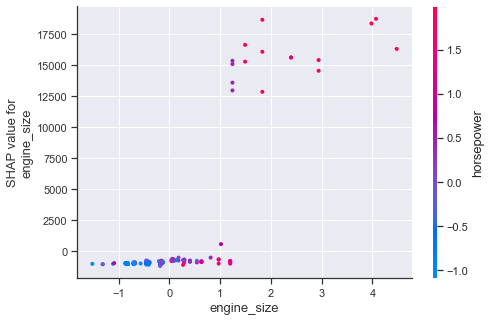

In [22]:
shap.dependence_plot("engine_size", shap_values2, car_X_train_tf)

In [29]:
sample2 = [116,42,109]
shap.force_plot(ex2.expected_value, shap_values2[sample2[0],:], car_X_train_tf.iloc[sample2[0],:])

In [30]:
shap.force_plot(ex2.expected_value, shap_values2[sample2[1],:], car_X_train_tf.iloc[sample2[1],:])

In [31]:
shap.force_plot(ex2.expected_value, shap_values2[sample2[2],:], car_X_train_tf.iloc[sample2[2],:])

-------

## 4. Conclusion

In this notebook, were interested in the interpretability of the ML models used in another [notebook](https://github.com/gabrielleuzinger/Automobile_price) to predict car prices based on the 'Automobile Data Set' from the UC Irvine Machine Learning repository. 

**We were able to verify some interesting patterns in the models and explain how they are reaching the predictions**.